# Project 3: Face Recognition Using the SVD.

### Group 7
### Sheng Han Yueh, Harsha Koduri
### 21.12.2022

The project aims to utilize SVD decomposition to recognize faces. The method helps us to use a smaller subspace to recognize the query photos. We utilized the Yale database, which includes 165 photos for 15 individuals and each person had 11 photos with different angles or lighting directions. By creating the known face space, we can project the query photo into the same space and find the prediction result that has the smallest Euclidean distance between the query and each known face. In this study, we discuss the accuracy, execution time, and memory usage when using original space and reduced space to recognize faces. 

In [1]:
import glob
import numpy as np
import PIL
from PIL import Image
import matplotlib.image as image
import matplotlib.pyplot as plt
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import urllib
from sklearn.utils import shuffle
import psutil
import dask.array as da
import random
from datetime import datetime
import tracemalloc

C:\Users\User\anaconda3\envs\New_one\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Activity 1 Read files and display the images

We gathered all the file name from the database and plotted the file with ".centerlight" for each person.  

In [2]:
def get_filenames(url_path):
    '''
    input: url for the folder in Github, a string
    output: all the file names in that folder, string in a list
    '''
    result = requests.get(url_path)
    soup = BeautifulSoup(result.content, 'html.parser')
    data=str(result.content)
    res=list(set(re.findall('subject\d\d.[a-z]+',data)))
    return res

In [3]:
path ='https://github.com/YSH-314/Numerical-Methods-AIM-5003-/tree/main/SVD%20face%20recognition/yaledatabase'

In [4]:
files=get_filenames(path)

In [5]:
files.sort()

In [6]:
files

['subject01.centerlight',
 'subject01.glasses',
 'subject01.happy',
 'subject01.leftlight',
 'subject01.noglasses',
 'subject01.normal',
 'subject01.rightlight',
 'subject01.sad',
 'subject01.sleepy',
 'subject01.surprised',
 'subject01.wink',
 'subject02.centerlight',
 'subject02.glasses',
 'subject02.happy',
 'subject02.leftlight',
 'subject02.noglasses',
 'subject02.normal',
 'subject02.rightlight',
 'subject02.sad',
 'subject02.sleepy',
 'subject02.surprised',
 'subject02.wink',
 'subject03.centerlight',
 'subject03.glasses',
 'subject03.happy',
 'subject03.leftlight',
 'subject03.noglasses',
 'subject03.normal',
 'subject03.rightlight',
 'subject03.sad',
 'subject03.sleepy',
 'subject03.surprised',
 'subject03.wink',
 'subject04.centerlight',
 'subject04.glasses',
 'subject04.happy',
 'subject04.leftlight',
 'subject04.noglasses',
 'subject04.normal',
 'subject04.rightlight',
 'subject04.sad',
 'subject04.sleepy',
 'subject04.surprised',
 'subject04.wink',
 'subject05.centerlight'

In [7]:
path = 'https://raw.githubusercontent.com/YSH-314/Numerical-Methods-AIM-5003-/main/SVD%20face%20recognition/yaledatabase'
from io import BytesIO
data=[]
for i in files:
    #print(i)
    url=path+"/"+i
    img=np.array(Image.open(BytesIO(requests.get(url, stream=True).content)).convert('L'))
    data.append(img)

In [8]:
data

[array([[130, 130, 130, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8),
 array([[130, 130, 130, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 252, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8),
 array([[130, 130, 130, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 249, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8),
 array([[130, 130, 130, ..., 216, 224, 244],
        [255, 255, 255, ..., 215, 220, 245],
        [255, 25

In [9]:
data[0].shape

(243, 320)

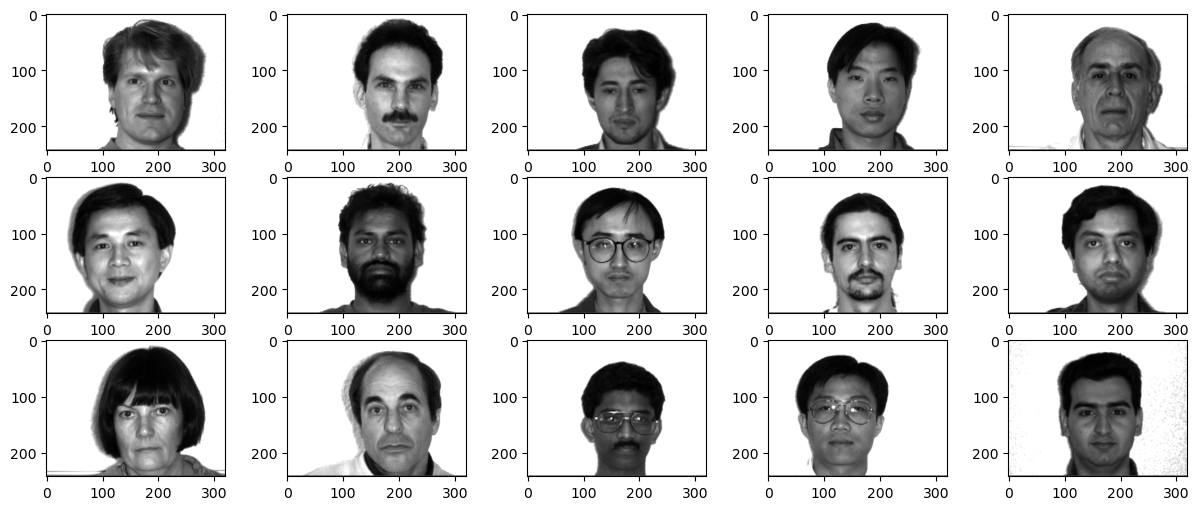

In [10]:
plt.figure(figsize=(15,6))
lo=0
for i in range(0,165,11):
    im=data[i]
    plt.subplot(3,5,lo+1) 
    plt.imshow(im,cmap='gray')
    lo+=1

There are 165 faces from 15 people and each person has 11 photos. The above figure demonstrated all 15 faces of different people. The shape of each photo is (243,320). The result showed we can successfully load data into jupyter notebook and display the images.

# Activity 2 Loading all the faces into a matrix and normalizing with a mean face

The self-defined function "img2vec" and "vec2img" are created to convert an image into a vector and display an image from a vector. They are reverse functions. Each image from the database has 243*320 pixels. By using the function "img2vec", we read the file and transferred the matrix into a vector with shape (243x320,1). The vector becomes one column in the matrix "dataset". In total, we loaded 165 faces and stored them as columns into a matrix "dataset". As a result, the shape of the "dataset" is (77760,165).

In [11]:
def img2vec(image):
    m,n=image.shape
    im=image.reshape(m*n,1)
    return im
    
    
def vec2img(array):
    plt.imshow(array.reshape(243,320),cmap='gray')
    

In [12]:
# The matrix "dataset" holds all the vectors that are transferred from image files. A column in the dataset is a face.
dataset=np.zeros((243*320,len(files)),dtype=np.float32)
for i in range(len(files)):
    fi=img2vec(data[i])
    dataset[:,i:i+1]=fi

In [13]:
dataset.shape

(77760, 165)

__Compute the mean face from 165 faces.__  
The shape of ave_f is (77760,). We display the mean face by reshaping the array ave_f to a matrix with (243,320) dimensions.

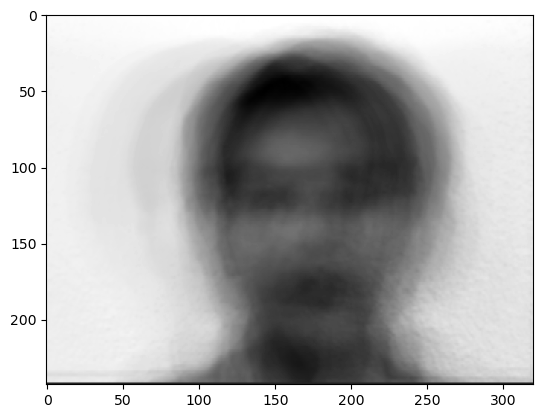

In [14]:
ave_f=np.mean(dataset,axis=1)
vec2img(ave_f)

__Normalized the dataset by substracting the mean face to each column in the dataset.__

In [15]:
norm_dataset=np.zeros(dataset.shape,dtype=np.float32)
for i in range(dataset.shape[1]):
    norm_dataset[:,i]=dataset[:,i]-ave_f

__Check the result__

In [16]:
ave_f[:40]

array([123.48485 , 123.509094, 123.77576 , 125.07273 , 125.53939 ,
       125.72727 , 126.55758 , 126.69091 , 126.472725, 126.02425 ,
       125.642426, 125.74545 , 124.721214, 124.35152 , 125.72727 ,
       126.78788 , 127.10303 , 126.96364 , 126.64848 , 125.7697  ,
       126.4     , 127.163635, 127.181816, 127.32121 , 127.00606 ,
       126.781815, 127.4     , 126.89091 , 126.00606 , 125.84242 ,
       126.04243 , 125.90909 , 126.15151 , 126.22424 , 126.29091 ,
       127.29697 , 127.98788 , 127.81212 , 127.666664, 127.569695],
      dtype=float32)

In [17]:
dataset[:40,0]

array([130., 130., 130., 130., 130., 130., 130., 130., 130., 130., 130.,
       130., 130., 130., 130., 130., 130., 130., 130., 130., 130., 130.,
       130., 130., 130., 130., 130., 130., 130., 130., 130., 130., 130.,
       130., 130., 130., 130., 130., 130., 130.], dtype=float32)

In [18]:
norm_dataset[:40,0]

array([6.515152 , 6.490906 , 6.224243 , 4.927269 , 4.4606094, 4.272728 ,
       3.442421 , 3.3090897, 3.527275 , 3.9757538, 4.3575745, 4.254547 ,
       5.2787857, 5.6484833, 4.272728 , 3.21212  , 2.8969727, 3.0363617,
       3.3515167, 4.230301 , 3.5999985, 2.8363647, 2.818184 , 2.6787872,
       2.9939423, 3.2181854, 2.5999985, 3.1090927, 3.9939423, 4.1575775,
       3.957573 , 4.090912 , 3.8484879, 3.7757568, 3.7090912, 2.7030334,
       2.012123 , 2.1878815, 2.3333359, 2.4303055], dtype=float32)

We randomly pick several indexes in norm_dataset to make sure we successfully normalized the dataset. 

# Activity 3 Divide the dataset into two disjoint sets

There are 15 people and each has 11 photos. We want to have the same number of photos in each person in F and Q datasets. First, we randomly picked the same number of indexes from [0 to 10],[11 to 21],[22 to 32],.....,[154 to 164] to be the "pick" list. These are the index that we chose to be F. The other index not in the pick list will be the query set, Q. Since the shuffle function only works on rows, we transposed the data matrix before shuffling. The output of data needs to be transposed again. Finally, we randomly pick a column in F and compared it by reading the file by its label to check whether the labeling is correct. The result showed the same array. 

In [19]:
def shuffle_by_column(X,Y):
    '''
    input: X: dataset in a matrix
           Y: label in a list
    '''
    temp=np.transpose(X)
    x,y = shuffle(temp, Y) # the data and label will have the the same order
    return np.transpose(x),y
    
def split_data(num_train,database):
    '''
    input: num_train should less than 11
    '''
    #np.random.seed(123)
    m,n=database.shape
    label=files
    pick=[]
    for i in range(15):
        #print(i)
        pick+=random.sample(range(i*11,(i+1)*11,1), num_train)
        #print(pick)
    F,F_y=shuffle_by_column(database[:,pick],[label[i] for i in pick])
    Q,Q_y=shuffle_by_column(database[:,[i for i in range(n) if i not in pick]],[label[i] for i in range(n) if i not in pick])
    return F, Q, F_y, Q_y


__Check the result by spliting 6 photos for each person__  
The expected shape of F is (77760,6x15), and the shape of Q is (77760, 5x15).

In [20]:
F, Q, F_y, Q_y=split_data(6,dataset)

In [21]:
F.shape

(77760, 90)

In [22]:
len(F_y)

90

In [23]:
F_y

['subject13.rightlight',
 'subject11.normal',
 'subject05.wink',
 'subject09.glasses',
 'subject01.wink',
 'subject04.sad',
 'subject06.wink',
 'subject04.glasses',
 'subject04.surprised',
 'subject07.leftlight',
 'subject15.surprised',
 'subject05.rightlight',
 'subject12.happy',
 'subject03.sleepy',
 'subject02.centerlight',
 'subject08.sleepy',
 'subject14.wink',
 'subject01.centerlight',
 'subject08.normal',
 'subject05.surprised',
 'subject10.surprised',
 'subject13.happy',
 'subject01.rightlight',
 'subject10.rightlight',
 'subject13.sad',
 'subject15.centerlight',
 'subject15.rightlight',
 'subject10.sad',
 'subject09.leftlight',
 'subject05.glasses',
 'subject04.leftlight',
 'subject03.glasses',
 'subject14.sleepy',
 'subject07.glasses',
 'subject02.leftlight',
 'subject03.wink',
 'subject07.wink',
 'subject08.leftlight',
 'subject11.wink',
 'subject02.happy',
 'subject01.surprised',
 'subject07.noglasses',
 'subject10.glasses',
 'subject02.surprised',
 'subject10.happy',
 'sub

In [24]:
Q.shape

(77760, 75)

In [25]:
len(Q_y)

75

In [26]:
Q_y

['subject04.centerlight',
 'subject02.rightlight',
 'subject09.normal',
 'subject14.sad',
 'subject14.leftlight',
 'subject12.normal',
 'subject07.surprised',
 'subject03.normal',
 'subject08.surprised',
 'subject04.rightlight',
 'subject06.noglasses',
 'subject03.rightlight',
 'subject01.happy',
 'subject13.noglasses',
 'subject06.surprised',
 'subject12.leftlight',
 'subject15.sad',
 'subject07.sad',
 'subject09.sleepy',
 'subject01.sad',
 'subject08.centerlight',
 'subject02.sleepy',
 'subject11.leftlight',
 'subject14.centerlight',
 'subject14.happy',
 'subject15.happy',
 'subject01.normal',
 'subject05.sleepy',
 'subject01.glasses',
 'subject04.wink',
 'subject03.surprised',
 'subject11.glasses',
 'subject04.sleepy',
 'subject12.centerlight',
 'subject08.glasses',
 'subject05.noglasses',
 'subject03.noglasses',
 'subject02.normal',
 'subject09.happy',
 'subject11.noglasses',
 'subject02.wink',
 'subject07.normal',
 'subject12.sad',
 'subject13.normal',
 'subject05.normal',
 'subje

__Check whether the label match to the reshuffle column__  
We randomly pick one of faces in the F dataset and read the file by its label. We compared the two vectors to make sure the labeling is correct. 

In [27]:
F_y[4]

'subject01.wink'

In [28]:
url=path+"/"+F_y[4]
img=np.array(Image.open(BytesIO(requests.get(url, stream=True).content)).convert('L'))

In [29]:
if (img2vec(img)==F[:,4].reshape(F.shape[0],1)).all():
    print('true')
else: print('false')

true


# Activity 4 Perform face recognition in the original image space

The variant "dataset" holds all the faces before normalization. We used a self-defined "split_data" function to split the dataset into F and Q datasets. By calculating the distance between the query and each column of F, the prediction result is the label of the column in F which has the minimum distance from the query.

In [30]:
def query(query,F):
    '''
    input: query_set is 1D-array from the column of Q 
           F is known faces 
    '''
    min_dist=np.inf
    #res=0
    test=query.flatten()
    for i in range(F.shape[1]):
        train=F[:,i].flatten()
        dist=np.linalg.norm(train-test)
        if dist<min_dist:
            min_dist=dist
            predict=F_y[i]
    return predict
        

__Split the original dataset__

In [31]:
F, Q, F_y, Q_y=split_data(6,dataset)

__Print the prediction results of the first 20 queries in Q dataset__

In [32]:
label=[]
predict=[]
for i in range(20):
    lab,pre=Q_y[i],query(Q[:,i],F)
    label.append(lab)
    predict.append(pre)
    print(f'#{i}\nlabel:{lab}\nprediction:{pre}')
    print()

#0
label:subject09.noglasses
prediction:subject09.normal

#1
label:subject11.rightlight
prediction:subject11.centerlight

#2
label:subject13.normal
prediction:subject13.wink

#3
label:subject07.normal
prediction:subject07.noglasses

#4
label:subject04.sleepy
prediction:subject04.glasses

#5
label:subject10.glasses
prediction:subject04.centerlight

#6
label:subject06.glasses
prediction:subject06.sleepy

#7
label:subject05.sad
prediction:subject05.sleepy

#8
label:subject04.rightlight
prediction:subject01.rightlight

#9
label:subject02.rightlight
prediction:subject12.rightlight

#10
label:subject02.sleepy
prediction:subject02.noglasses

#11
label:subject07.centerlight
prediction:subject10.normal

#12
label:subject08.sleepy
prediction:subject08.centerlight

#13
label:subject15.surprised
prediction:subject15.sleepy

#14
label:subject02.centerlight
prediction:subject02.noglasses

#15
label:subject14.sad
prediction:subject14.surprised

#16
label:subject03.sleepy
prediction:subject03.happy

#

### To check which category of picture causes mismatch
The following self-defined function summarized the mismatch results by the type of photos. 

In [33]:
def mismatch_count(lab, predict):
    match_res=pd.DataFrame(list(zip(lab,predict)),columns =['label', 'predict'])
    match_res['label_number']=match_res['label'].str.extract(r'subject([\d]*)',expand=True)
    match_res['predict_number']=match_res['predict'].str.extract(r'subject([\d]*)',expand=True)
    match_res['label_cat']=match_res['label'].str.split(r'.',expand=True)[1]
    false_pre=match_res['label_number']!=match_res['predict_number']
    return match_res[false_pre].groupby('label_cat')['label'].count()
    

In [34]:
mismatch_count(label, predict)

label_cat
centerlight    1
glasses        1
leftlight      1
rightlight     2
Name: label, dtype: int64

When the picture is "rightlight" or "leftlight", the prediction result usually is not matched.

# Activity 5 Query every image in the query set in the original space
We utilized the original space to do the face recognition. By taking different numbers of photos as F, we compared the accuracy changes between the results. 

In [35]:
def accuracy(lab, predict):
    '''
    input: the label and the predicted results in lists
    output: the accuracy rate in percent
    '''
    total=0 # record the number of photos that match to the label
    for l,p in zip(lab,predict):
        y=re.findall(r'\d+',l) # extract the subject number in label
        y_pre=re.findall(r'\d+',p)# extract the subject number in predicted result
        if y==y_pre:
            total+=1
    return total/len(lab)*100

### When taking each person for 6 pictures as training and 5 as testing

In [36]:
F, Q, F_y, Q_y=split_data(6,dataset)

In [37]:
len(Q_y)

75

In [38]:
start_time = datetime.now()
tracemalloc.start()
lab,predict=Q_y,[]
for i in range(len(Q_y)):
    predict.append(query(Q[:,i],F))
end_time = datetime.now()
print('accuracy:',accuracy(lab, predict),'%')
print('RAM used in MB:', tracemalloc.get_traced_memory()[1]/1000000)
print('RAM Used (GB):',tracemalloc.get_traced_memory()[1]/1000000000)
print('Duration (s): {}'.format((end_time - start_time).total_seconds()))
tracemalloc.stop()

accuracy: 84.0 %
RAM used in MB: 1.231771
RAM Used (GB): 0.001231771
Duration (s): 0.424895


In [39]:
mismatch_count(lab, predict)

label_cat
centerlight    1
glasses        1
leftlight      4
noglasses      1
rightlight     4
sad            1
Name: label, dtype: int64

### When taking each person for 9 pictures as training and 2 as testing

In [40]:
F, Q, F_y, Q_y=split_data(9,dataset)

In [41]:
len(Q_y)

30

In [42]:
start_time = datetime.now()
tracemalloc.start()
lab,predict=Q_y,[]
for i in range(len(Q_y)):
    predict.append(query(Q[:,i],F))
end_time = datetime.now()
print('accuracy:',accuracy(lab, predict),'%')
print('RAM used in MB:', tracemalloc.get_traced_memory()[1]/1000000)
print('RAM Used (GB):',tracemalloc.get_traced_memory()[1]/1000000000)
print('Duration (s): {}'.format((end_time - start_time).total_seconds()))
tracemalloc.stop()

accuracy: 80.0 %
RAM used in MB: 1.083123
RAM Used (GB): 0.001083123
Duration (s): 0.243349


In [43]:
mismatch_count(lab, predict)

label_cat
centerlight    2
leftlight      3
noglasses      1
Name: label, dtype: int64

The accuracy might be influenced by the type of picture. For instance, if we only left the "rightlight" as the testing set, then the accuracy may severely drop.

### When taking each person for 4 pictures as training and 7 as testing

In [44]:
F, Q, F_y, Q_y=split_data(4,dataset)

In [45]:
len(Q_y)

105

In [46]:
start_time = datetime.now()
tracemalloc.start()
lab,predict=Q_y,[]
for i in range(len(Q_y)):
    predict.append(query(Q[:,i],F))
end_time = datetime.now()
print('accuracy:',accuracy(lab, predict),'%')
print('RAM used in MB:', tracemalloc.get_traced_memory()[1]/1000000)
print('RAM Used (GB):',tracemalloc.get_traced_memory()[1]/1000000000)
print('Duration (s): {}'.format((end_time - start_time).total_seconds()))
tracemalloc.stop()

accuracy: 79.04761904761905 %
RAM used in MB: 1.083643
RAM Used (GB): 0.001083643
Duration (s): 0.361033


In [47]:
mismatch_count(lab, predict)

label_cat
centerlight     3
glasses         1
leftlight      11
noglasses       1
normal          1
rightlight      4
surprised       1
Name: label, dtype: int64

### Explore the change of accuracy when taking different number of pictures per person as F

Since the pictures in F is randomly picked and different type of pictures influence the prediction result, we repeatedly sampled 10 times to know how the accuracy changed when using a different number of pictures per person as F.

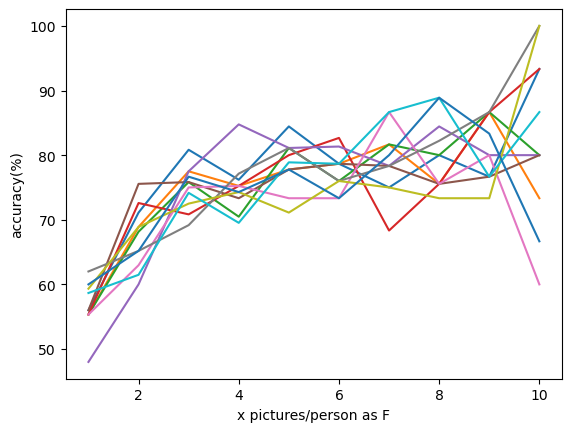

In [48]:
for j in range(11):
    acc_all=[]
    for num in range(1,11):
        #print(num)
        F, Q, F_y, Q_y=split_data(num,dataset)
        lab,predict=Q_y,[]
        for i in range(len(Q_y)):
            predict.append(query(Q[:,i],F))
        acc_all.append(accuracy(lab, predict))
    plt.plot([i for i in range(1,11)],acc_all)
    plt.ylabel('accuracy(%)')
    plt.xlabel('x pictures/person as F')   

### The trend demonstrated if using more pictures as F, the accuracy increased. However, the accuracy is easily affected by the type of pictures, causing low accuracy in some combinations.

# Activity 6 Perform recognition in the reduced face space
We took 9 photos per person from norm_dataset. We utilized SVD to decompose the normalized matrix F. Finally, we displayed the reduced based faces.

In [49]:
F, Q, F_y, Q_y=split_data(9,norm_dataset)

__Calculate the rank of known face matrix, F__

In [50]:
r=np.linalg.matrix_rank(F)
print('Rank:',r)

Rank: 127


In [51]:
M,N=F.shape
print('M:',M)
print('N:',N)

M: 77760
N: 135


Since $rank < = min(M,N)$, F has SVD.

In [52]:
u, s, vt = da.linalg.svd(da.asarray(F)) 

In [53]:
u, s, vt = np.array(u),np.array(s),np.array(vt)

The columns of left singular matrix, u, are the set of orthonormal eigenvectors of $FF^T$

In [54]:
u

array([[ 2.8398781e-04,  9.7142614e-04, -6.7724504e-05, ...,
        -1.3714299e-02,  3.9860744e-02, -9.2535339e-02],
       [ 4.8484400e-04,  1.1262125e-03, -9.3671915e-05, ...,
         1.0909426e-03,  2.4132284e-03,  5.2049956e-03],
       [ 5.8701431e-04,  1.1843441e-03, -7.9821650e-05, ...,
        -4.2995345e-03, -3.3924726e-04, -1.4611204e-02],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [55]:
u.shape

(77760, 135)

The norm of column vector in u should be 1

In [56]:
(u[:,2].T@u[:,2])**0.5

1.0

Since the colums in u are all normalized orthogonal vectors, the dot product of two columns is 0

In [57]:
u[:,123]@u[:,1]

-1.954037e-11

The singular value in "s" is ordered by descending. $S_i$ is the $\sqrt{\lambda_i}$, where $\lambda_i$ are the eigenvalues of $F^TF$.

In [58]:
s

array([1.1665163e+05, 7.9147766e+04, 6.2703773e+04, 5.6626461e+04,
       4.7014895e+04, 4.4508121e+04, 3.5012094e+04, 3.2859371e+04,
       3.2033723e+04, 2.9540381e+04, 2.5655891e+04, 2.3592586e+04,
       2.1596789e+04, 2.1169631e+04, 2.0880566e+04, 1.9606471e+04,
       1.8684656e+04, 1.8070037e+04, 1.7774178e+04, 1.6751730e+04,
       1.6524148e+04, 1.4643786e+04, 1.4133482e+04, 1.3679655e+04,
       1.3294346e+04, 1.3130565e+04, 1.2811620e+04, 1.2201450e+04,
       1.1740911e+04, 1.1712712e+04, 1.1342166e+04, 1.0883919e+04,
       1.0760022e+04, 1.0534929e+04, 1.0242850e+04, 1.0054012e+04,
       9.8211260e+03, 9.5027793e+03, 9.3146182e+03, 9.2165869e+03,
       9.0947588e+03, 8.7352383e+03, 8.5437969e+03, 8.4145625e+03,
       8.2477500e+03, 8.2195391e+03, 8.0409380e+03, 8.0330688e+03,
       7.8552900e+03, 7.6845903e+03, 7.5886890e+03, 7.4680815e+03,
       7.3333306e+03, 7.2788276e+03, 7.2177817e+03, 7.1829375e+03,
       7.0193511e+03, 6.9348062e+03, 6.8823071e+03, 6.6777549e

In [59]:
s.shape

(135,)

The columns of right singular matrix, v, are the set of orthonormal eigenvectors of $F^TF$

In [60]:
vt

array([[-3.51790749e-02, -1.51689366e-01, -1.49369687e-01, ...,
        -2.12211773e-01,  1.02679648e-01,  6.86429963e-02],
       [ 1.07850261e-01, -3.63033563e-02, -4.48591188e-02, ...,
        -1.49482250e-01, -1.40873000e-01,  2.17943694e-02],
       [-7.26641640e-02,  3.20468508e-02,  7.09748492e-02, ...,
         2.69825570e-02, -2.43640810e-01,  4.42271493e-02],
       ...,
       [ 0.00000000e+00,  5.77676470e-17, -3.05991340e-16, ...,
         4.61870125e-17,  1.04896560e-17,  1.04083409e-17],
       [-0.00000000e+00,  1.88254767e-16, -1.03061027e-16, ...,
        -1.08420217e-16, -3.12250226e-17,  4.42354486e-17],
       [ 0.00000000e+00, -4.80586165e-16, -9.01928160e-17, ...,
        -4.33680869e-17, -4.16333634e-17, -6.93889390e-18]], dtype=float32)

In [61]:
vt.shape

(135, 135)

In [62]:
v=vt.T

The norm of column vector in v should be 1

In [63]:
(v[:,2].T@v[:,2])**0.5

1.0

Since the colums in v are all normalized orthogonal vectors, the dot product of two columns is 0

In [64]:
v[:,134]@v[:,10]

-8.684825e-18

### Plot the base faces
The base faces, u, are normalized eigenvectors. To display the image, we adjusted the vector from a scale of 1 to a scale of 255

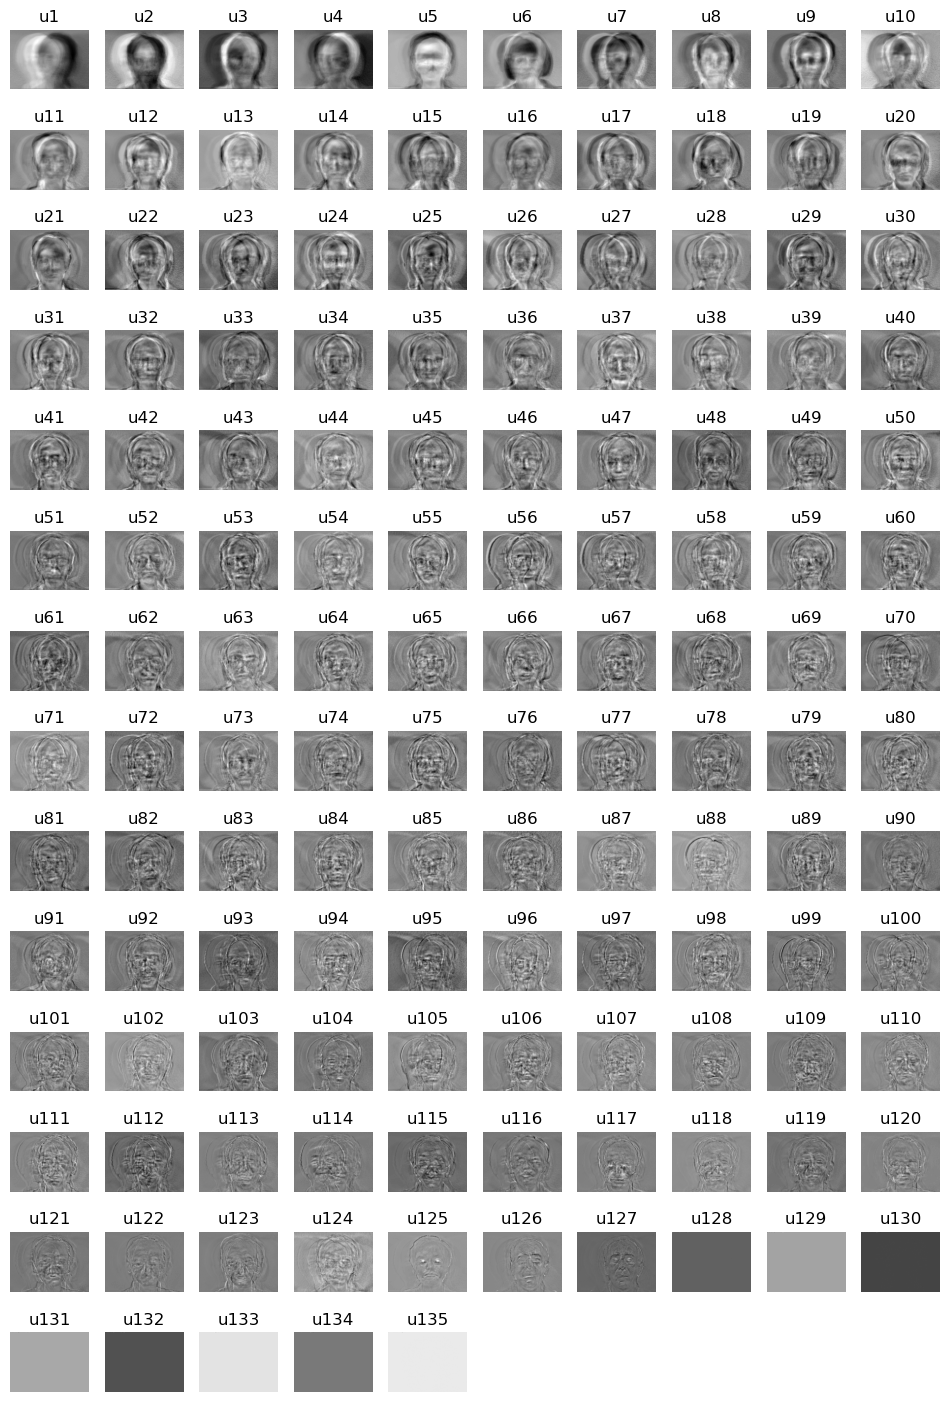

In [65]:
plt.figure(figsize=(12,18))
lo=0
for i in range(u.shape[1]):
    arr=u[:,i]
    arr=arr*255/np.max(arr)
    plt.subplot(14,10,lo+1) 
    vec2img(arr)
    plt.title(f'u{i+1}')
    plt.axis('off')
    lo+=1

# Activity 7 Select the dimension p of the face space
To reduce the matrix and in the meantime not loosing too much information, we decided on the number of dimensions from three aspects. The first is based on the trend of singular value. We used the line plot to demonstrate the trend of singular values. By calculating the cumulative singular value and dividing it by the sum of all singular values, we displayed the ratio of cumulation. The value of p was picked when one more dimension can't provide over an additional 1% of the information. The second method was to visualize the photos under different p dimensions. We picked the value of p when found the contour is clear. The third one is to calculate the norm of the distance between the original matrix, F, and the reduced matrix, F_p. The value of p is the one that has the shortest distance between F and F_p. 

In [66]:
s

array([1.1665163e+05, 7.9147766e+04, 6.2703773e+04, 5.6626461e+04,
       4.7014895e+04, 4.4508121e+04, 3.5012094e+04, 3.2859371e+04,
       3.2033723e+04, 2.9540381e+04, 2.5655891e+04, 2.3592586e+04,
       2.1596789e+04, 2.1169631e+04, 2.0880566e+04, 1.9606471e+04,
       1.8684656e+04, 1.8070037e+04, 1.7774178e+04, 1.6751730e+04,
       1.6524148e+04, 1.4643786e+04, 1.4133482e+04, 1.3679655e+04,
       1.3294346e+04, 1.3130565e+04, 1.2811620e+04, 1.2201450e+04,
       1.1740911e+04, 1.1712712e+04, 1.1342166e+04, 1.0883919e+04,
       1.0760022e+04, 1.0534929e+04, 1.0242850e+04, 1.0054012e+04,
       9.8211260e+03, 9.5027793e+03, 9.3146182e+03, 9.2165869e+03,
       9.0947588e+03, 8.7352383e+03, 8.5437969e+03, 8.4145625e+03,
       8.2477500e+03, 8.2195391e+03, 8.0409380e+03, 8.0330688e+03,
       7.8552900e+03, 7.6845903e+03, 7.5886890e+03, 7.4680815e+03,
       7.3333306e+03, 7.2788276e+03, 7.2177817e+03, 7.1829375e+03,
       7.0193511e+03, 6.9348062e+03, 6.8823071e+03, 6.6777549e

### 7.1 Based on the changes in singular value to choose p dimension

Text(0.5, 0, 'p')

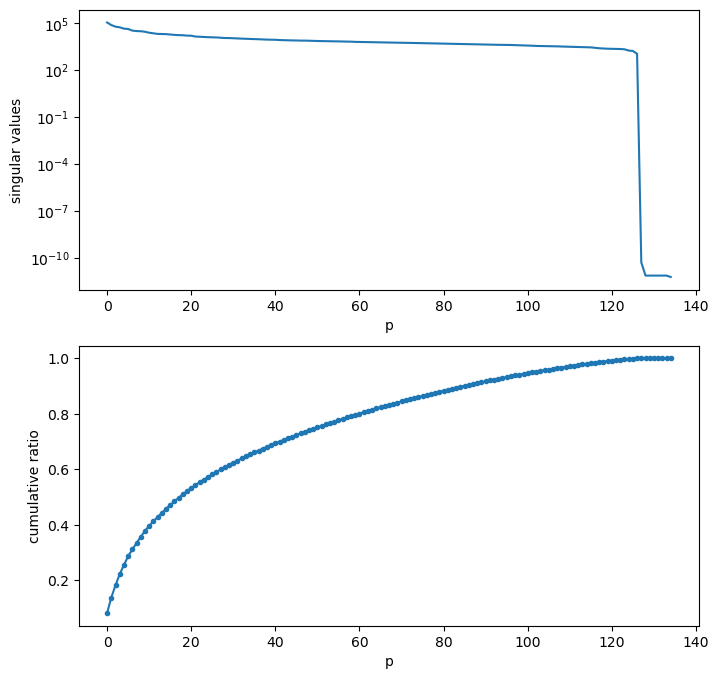

In [67]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
x=[i for i in range(s.shape[0])]
y=s
plt.semilogy(x,y)
plt.ylabel('singular values')
plt.xlabel('p')

plt.subplot(2,1,2)
cu_y=np.cumsum(s)/np.sum(s)
plt.plot(x,cu_y,'.-')
plt.ylabel('cumulative ratio')
plt.xlabel('p')

### Adjust the scale to zoom in the figure

(0.0, 80.0)

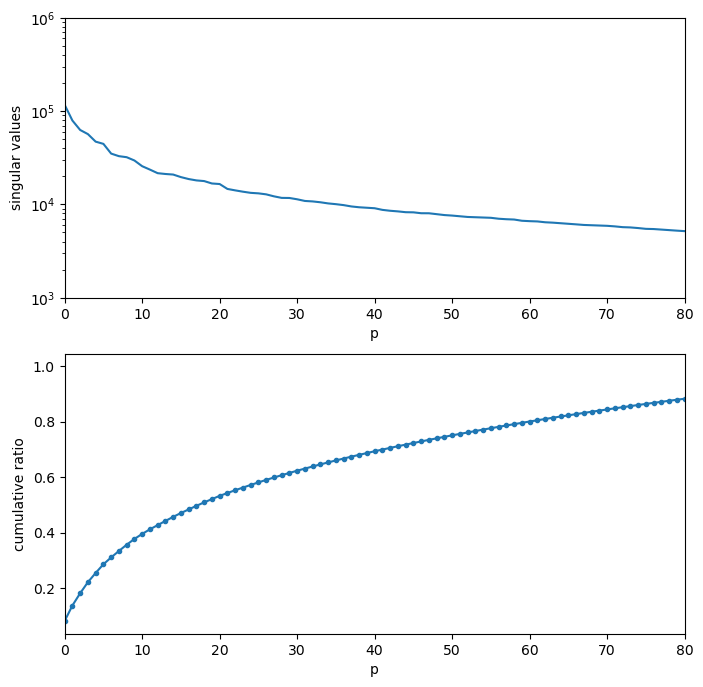

In [68]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
x=[i for i in range(s.shape[0])]
y=s
plt.semilogy(x,y)
plt.ylabel('singular values')
plt.xlabel('p')
plt.ylim(1e3,1e6)
plt.xlim(0,80)

plt.subplot(2,1,2)
cu_y=np.cumsum(s)/np.sum(s)
plt.plot(x,cu_y,'.-')
plt.ylabel('cumulative ratio')
plt.xlabel('p')
plt.xlim(0,80)

The sigular value did not decrease much after 30 dimensions. The cumulative ratio with 30 dimensions is around 60%. The cumulative ratio demonstrates the content of information (%) in each dimension.

In [69]:
slope=[]
for i in range(1,len(cu_y)):
    slope.append((cu_y[i]-cu_y[i-1])*100)

In [70]:
res=pd.DataFrame(cu_y*100,columns=['cumulative ratio (%)'])
res['delta ratio (%)']=[cu_y[0]*100]+slope

In [71]:
res

,cumulative ratio (%),delta ratio (%)
0,8.226321,8.226321
1,13.807854,5.581533
2,18.229750,4.421896
3,22.223072,3.993322
4,25.538582,3.315510
...,...,...
130,100.000023,0.000000
131,100.000023,0.000000
132,100.000023,0.000000
133,100.000023,0.000000


In [72]:
res[res['delta ratio (%)']<=1.1]

,cumulative ratio (%),delta ratio (%)
21,54.374676,1.032686
22,55.371372,0.996697
23,56.336067,0.964695
24,57.273598,0.937527
25,58.199566,0.925970
...,...,...
130,100.000023,0.000000
131,100.000023,0.000000
132,100.000023,0.000000
133,100.000023,0.000000


We picked the p dimensions when the next dimension can't provide over an additional 1% of the information.

In [73]:
p1=res[res['delta ratio (%)']>=1].shape[0]

In [74]:
p1

22

### 7.2 Visulize pictures with different p dimensions and choose p

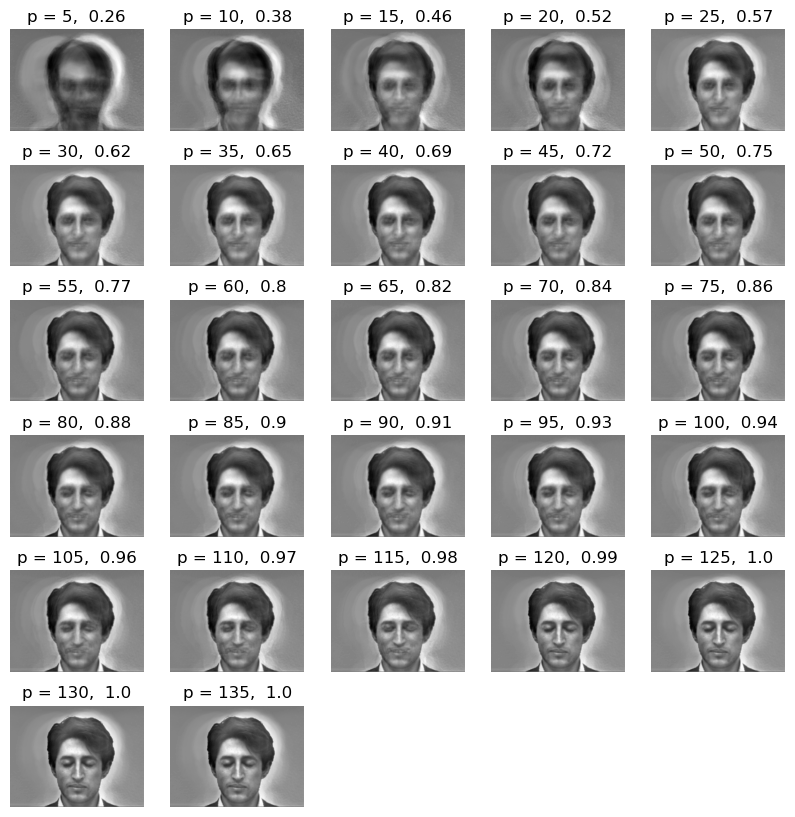

In [75]:
plt.figure(figsize=(10,12))
lo=1
for i in range(5, u.shape[1]+1, 5):
    plt.subplot(7,5,lo)
    reconstimg = np.matrix(u[:, :i]) @ np.diag(s[:i]) @ np.matrix(vt[:i, :])
    arr=reconstimg[:,13]
    vec2img(arr)
    title = "p = %s" % i+',  '+str(round(cu_y[i-1],2))
    plt.title(title)
    plt.axis('off')
    #plt.show()
    lo+=1

When p equals to 40, we can clearly see the contour.

In [76]:
p2=40

### 7.3 Choose p by norm of distance between original matrix and reduced matrix
The value of p should be the rank of matrix F

In [77]:
norm=[]
p=[]
for i in range(1,u.shape[1]+1):
    p.append(i)
    F_p=np.matrix(u[:, :i]) @ np.diag(s[:i]) @ np.matrix(vt[:i, :])
    norm.append(np.linalg.norm(F-F_p))
    

Text(0.5, 0, 'p dimensions')

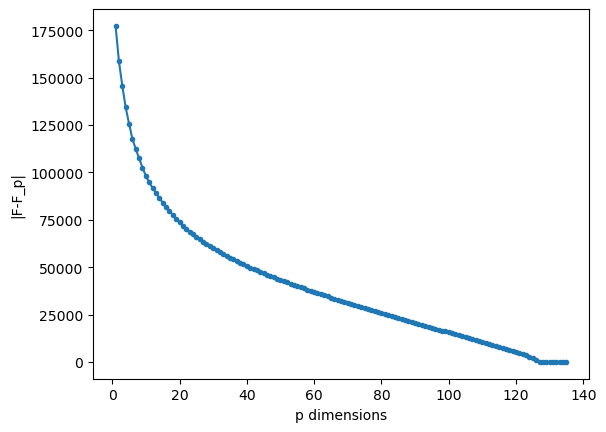

In [78]:
plt.plot(p,norm,'.-')
plt.ylabel('|F-F_p|')
plt.xlabel('p dimensions')

In [79]:
dist_res=pd.DataFrame(list(zip(p,norm)),columns =['p dimension', '|F-F_p|'])
dist_res

,p dimension,|F-F_p|
0,1,177285.765625
1,2,158631.968750
2,3,145716.328125
3,4,134268.671875
4,5,125770.390625
...,...,...
130,131,0.059856
131,132,0.059856
132,133,0.059856
133,134,0.059856


In [80]:
dist_res.iloc[-20:,:]

,p dimension,|F-F_p|
115,116,7513.623047
116,117,6976.457520
117,118,6473.974121
118,119,5964.364258
119,120,5445.829590
120,121,4885.741699
121,122,4273.287109
122,123,3583.312744
123,124,2800.635986
124,125,2090.793213


In [81]:
p3=r

In [82]:
p3

127

# Activity 8 Utilized reduced face space to recognize query set.
In this question, we discuss the execution time, the memory usage, and the prediction accuracy under different p dimensions. 

### 8.1 Compare the prediction result and efficiency under p1, p2, and p3 dimensions

In [83]:
import tracemalloc
list_p=[p1,p2,p3]
for i in list_p:
    start_time = datetime.now()
    tracemalloc.start()

    lab,predict=Q_y,[]
    base_u=u[:,:i]
    reduced_F=np.dot(base_u.T,F)
    reduced_Q=np.dot(base_u.T,Q)
    for j in range(len(Q_y)):
        predict.append(query(reduced_Q[:,j],reduced_F))
    end_time = datetime.now()
    

    print('p =',i)
    print('reduced_F.shape=',reduced_F.shape)
    print('reduced_Q.shape=',reduced_Q.shape)
    print('accuracy with reduced base:',accuracy(lab, predict),'%')
    print('RAM used in MB:', tracemalloc.get_traced_memory()[1]/1000000)
    print('RAM Used (GB)',tracemalloc.get_traced_memory()[1]/1000000000)
    print('Duration (s): {}'.format((end_time - start_time).total_seconds()))
    print('---------------------------------------------------------------------')
    tracemalloc.stop()
    

p = 22
reduced_F.shape= (22, 135)
reduced_Q.shape= (22, 30)
accuracy with reduced base: 60.0 %
RAM used in MB: 7.153826
RAM Used (GB) 0.007153826
Duration (s): 0.112695
---------------------------------------------------------------------
p = 40
reduced_F.shape= (40, 135)
reduced_Q.shape= (40, 30)
accuracy with reduced base: 63.33333333333333 %
RAM used in MB: 12.616503
RAM Used (GB) 0.012616503
Duration (s): 0.091785
---------------------------------------------------------------------
p = 127
reduced_F.shape= (127, 135)
reduced_Q.shape= (127, 30)
accuracy with reduced base: 63.33333333333333 %
RAM used in MB: 39.736011
RAM Used (GB) 0.039736011
Duration (s): 0.186471
---------------------------------------------------------------------


We used the whole dimension to predict the results and compared them with the prediction results from reduced subspace.

In [84]:
start_time = datetime.now()
tracemalloc.start()

lab,predict=Q_y,[]
for i in range(len(Q_y)):
    predict.append(query(Q[:,i],F))
end_time = datetime.now()



ori_acc=accuracy(lab, predict)
ori_ram=psutil.virtual_memory()[2]
ori_ram_GB=psutil.virtual_memory()[3]/1000000000
ori_time=(end_time - start_time).total_seconds()

print('original dimension')
print('accuracy with original base:',ori_acc,'%')
print('F.shape=',F.shape)
print('Q.shape=',Q.shape)
print('RAM Used MB',tracemalloc.get_traced_memory()[1]/1000000)
print('RAM Used (GB)',tracemalloc.get_traced_memory()[1]/1000000000)
print('Duration (s): {}'.format(ori_time))
tracemalloc.stop()


original dimension
accuracy with original base: 63.33333333333333 %
F.shape= (77760, 135)
Q.shape= (77760, 30)
RAM Used MB 1.230795
RAM Used (GB) 0.001230795
Duration (s): 0.26529


__The result demonstrated that when using higher dimensions to do face recognition, the accuracy increased. However, we could use a much smaller subspace (77760 v.s 40) to reach a similar accuracy. The execution time is much shorter when using reduced subspace. Surprisingly, the RAM usage is much smaller in the original space. We assumed the reduced space needed to store additional variants, such as projected subspace for F and Q, resulting in more RAM used in this case.__  

### 8.2 Calculating the accuracy for different p dimensions

In [85]:
all_ram=[]
all_ram_GB=[]
all_time=[]
all_p=[]
all_acc=[]
for pval in range(1,F.shape[1]+1):
    start_time = datetime.now()
    tracemalloc.start()
    lab,predict=Q_y,[]
    all_p.append(pval)
    base_u=u[:,:pval]
    temp_reduced_F=base_u.T@F
    temp_reduced_Q=base_u.T@Q
    for i in range(len(Q_y)):
        predict.append(query(temp_reduced_Q[:,i],temp_reduced_F))
    all_acc.append(accuracy(lab, predict))
    end_time = datetime.now()
    all_time.append((end_time - start_time).total_seconds())
    all_ram.append(tracemalloc.get_traced_memory()[1]/1000000)
    all_ram_GB.append(tracemalloc.get_traced_memory()[1]/1000000000)
    tracemalloc.stop()
    

Text(0, 0.5, 'prediction accuracy (%)')

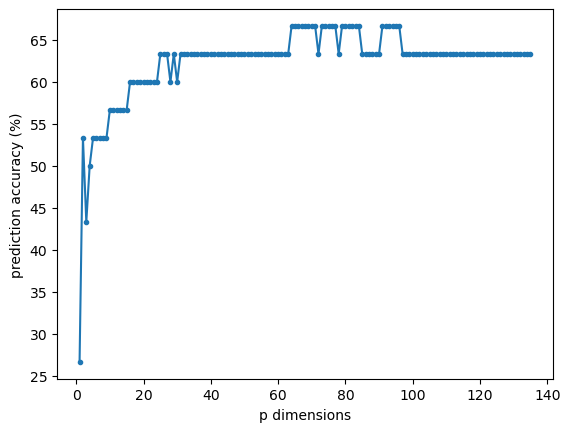

In [86]:
plt.plot(all_p,all_acc,'.-')
plt.xlabel('p dimensions')
plt.ylabel('prediction accuracy (%)')

Text(0, 0.5, 'RAM used (MB)')

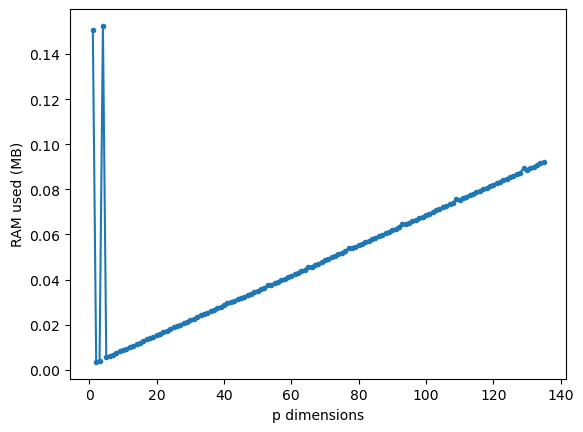

In [87]:
plt.plot(all_p,all_ram,'.-')
plt.xlabel('p dimensions')
plt.ylabel('RAM used (MB)')
#plt.ylim(60,70)

Text(0, 0.5, 'Milliseconds (ms)')

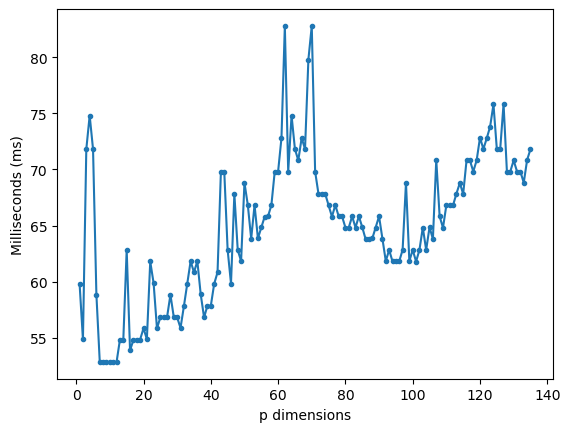

In [88]:
plt.plot(all_p,np.array(all_time)*1000,'.-')
plt.xlabel('p dimensions')
plt.ylabel('Milliseconds (ms)')

We found using the reduced subspace, which p is around 40, reaches the same accuracy as with full base-faces. The execution time was reduced to around 15 ms. The absolute RAM usage is easily affected by the variant we stored, resulting in being hard to compare between different p base-faces.

# Conclusion

__In this study, we utilized a small face database to discuss whether SVD is beneficial to apply to face recognition. In terms of efficiency, the reduced subspace only costs half of the execution time as the original space (0.113 s v.s 0.265 s in the table of activity 8). In terms of accuracy, we reduced the dimension from 77760 to 127 without changing the prediction accuracy. And we further used less number of base faces to reduce the size of the matrix, and the accuracy only slightly dropped. Through the result, SVD is a robust tool used in face recognition. We think there is a dilemma in deciding the number of base faces since the accuracy declined when reducing the content of information. In activity 7, we applied three methods to determine p value. The most reasonable and automatic way is the first one that depends on the change in the content of information. We might find the optimized cut-off for p base faces with the least dimension and the best accuracy.__ 

# References:
1. Sauer, Tim. 2018. Numerical Analysis. N.p.: Pearson.
2. K Elleithy, 2007. Advances and Innovations in Systems, Computing Sciences and Software Engineering (ISBN : 978-1-4020-6263-6)
3. Shuffle by column: https://stackoverflow.com/questions/20546419/shuffle-columns-of-an-array-with-numpy
4. Calculate memory used: https://www.geeksforgeeks.org/how-to-get-current-cpu-and-ram-usage-in-python/
5. Read pictures from a url: https://gist.github.com/clbarnes/9084b6490284a5f9f548829caf19400d
6. https://web.stanford.edu/class/cs168/l/l9.pdf
7. Plotting the singular values and cumulative ratio: https://www.youtube.com/watch?v=gXbThCXjZFM&ab_channel=SteveBrunton
8. Dask svd: https://docs.dask.org/en/stable/generated/dask.array.linalg.svd.html
